# CS728: Assignment 3 

This assignment is based on the answer type classification of queries. You are given in the [dataset](https://drive.google.com/file/d/1oRMV-wX6iGqj9gnbNYcEVNUZ6-hE_iBD/view?usp=sharing) queries from the WebQSP dataset and the corresponding target answer types. 


## Basic Approach:

You have to train a multiclass BERT based classifier for the task. You can input the question to a pretrained BERT base model and use the CLS embeddings for multiclass classification. This constitutes the basic approach to this task.

In [1]:
import os
os.chdir("/content/drive/MyDrive/CS728/Assignment3")

In [19]:
!pip install transformers
import pandas as pd
import numpy as np
from sklearn import metrics
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

     |████████████████████████████████| 2.1MB 7.8MB/s 
     |████████████████████████████████| 870kB 34.2MB/s 
     |████████████████████████████████| 3.3MB 51.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=9d88be42fee0a66b5c1c5671b569cb5f1c0765caddcbd81666c3e795d253e5ca
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [20]:
df = pd.read_json("train_type.json")
print(len(df))

df_exploded = df.explode("types").reset_index(drop=True)
print(len(df_exploded))

print("Number of unique types:\t", len(df_exploded["types"].unique()))

1763
5058
Number of unique types:	 137


In [21]:
df_exploded["types_factorized"] = pd.factorize(df_exploded["types"])[0]
labels = torch.tensor(df_exploded["types_factorized"])

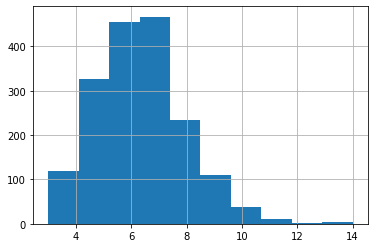

In [22]:
# Explore the distribution of question lengths

question_lens = df["text"].apply(lambda x: len(x.split()))
question_lens.hist()
max_len = max(question_lens) + 2

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

input_ids = []
attention_masks = []

for question in df_exploded["text"]:
    encoded_dict = tokenizer.encode_plus(
                        question,
                        add_special_tokens = True,          # Add '[CLS]' and '[SEP]'
                        max_length = max_len,               # Pad all sentences.
                        padding='max_length',
                        return_attention_mask = True,       # Construct attn. masks.
                        return_tensors = 'pt',              # Return pytorch tensors.
                   )
       
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

In [72]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [73]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,552 training samples
  506 validation samples


In [74]:
batch_size = 64
train_dataloader = DataLoader(
    train_dataset,                          # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size                 # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset,                                # The validation samples.
    sampler = SequentialSampler(val_dataset),   # Pull out batches sequentially.
    batch_size = batch_size                     # Evaluate with this batch size.
)

In [75]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 137,
    output_attentions = False,
    output_hidden_states = False, 
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [38]:
if torch.cuda.is_available():        # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())    
    print('We will use the GPU:', torch.cuda.get_device_name(0))# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [77]:
optim = AdamW(model.parameters(), lr=5e-6)

In [78]:
# Obtain the model performance prior to any training

epoch_predictions = []
epoch_labels = []
model.eval()

for batch in validation_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    epoch_predictions.append(torch.argmax(outputs[1], 1).detach().cpu().numpy())
    epoch_labels.append(labels.detach().cpu().numpy())

epoch_validation_micro_f1 = metrics.f1_score(np.concatenate(epoch_labels).ravel(), np.concatenate(epoch_predictions).ravel(), average="micro")

print(f"Micro F1:\t{epoch_validation_micro_f1}")

Micro F1:	0.0


In [39]:
def trainModel(model, optim, train_dataloader, validation_dataloader, epochs=10):
    losses = []

    best_model = None
    best_micro_f1 = 0
    train_losses = []
    valid_losses = []
    train_f1 = []
    valid_f1 = []

    for epoch in range(epochs):
        epoch_predictions = []
        epoch_labels = []
        epoch_losses = []

        model.train()
        for batch in train_dataloader:
            optim.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            epoch_losses.append(loss.detach().cpu().numpy())
            epoch_predictions.append(torch.argmax(outputs[1], 1).detach().cpu().numpy())
            epoch_labels.append(labels.detach().cpu().numpy())

            loss.backward()
            optim.step()

        epoch_train_loss = np.mean(epoch_losses)
        epoch_train_micro_f1 = metrics.f1_score(np.concatenate(epoch_labels).ravel(), np.concatenate(epoch_predictions).ravel(), average="micro")

        ###################################################### Validation ######################################################
        epoch_predictions = []
        epoch_labels = []
        epoch_losses = []
        model.eval()
        for batch in validation_dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            epoch_losses.append(loss.detach().cpu().numpy())
            epoch_predictions.append(torch.argmax(outputs[1], 1).detach().cpu().numpy())
            epoch_labels.append(labels.detach().cpu().numpy())

        epoch_validation_loss = np.mean(epoch_losses)
        epoch_validation_micro_f1 = metrics.f1_score(np.concatenate(epoch_labels).ravel(), np.concatenate(epoch_predictions).ravel(), average="micro")

        # Update the best model if needed
        if epoch_validation_micro_f1 > best_micro_f1:
            best_micro_f1 = epoch_validation_micro_f1
            best_model = model

        # Store the preformance metrics to be returned
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_validation_loss)
        train_f1.append(epoch_train_micro_f1)
        valid_f1.append(epoch_validation_micro_f1)

        # Display the metrics for each epoch
        print("[Epoch %d]\t[Training Loss: %.4f]\t[Validation Loss: %.4f]\t[Training Micro F1: %.4f]\t[Validation Micro F1: %.4f]" % (epoch+1, epoch_train_loss, epoch_validation_loss, epoch_train_micro_f1, epoch_validation_micro_f1))

    return best_model, {
        "train_loss": train_losses,
        "valid_loss": valid_losses,
        "train_micro_f1": train_f1,
        "valid_micro_f1": valid_f1
    }

In [80]:
model_approach1, approach1_metrics = trainModel(model, optim, train_dataloader, validation_dataloader)

[Epoch 1]	[Training Loss: 4.6831]	[Validation Loss: 4.3310]	[Training Micro F1: 0.0984]	[Validation Micro F1: 0.1285]
[Epoch 2]	[Training Loss: 3.9883]	[Validation Loss: 3.7499]	[Training Micro F1: 0.1997]	[Validation Micro F1: 0.2016]
[Epoch 3]	[Training Loss: 3.5539]	[Validation Loss: 3.4591]	[Training Micro F1: 0.2375]	[Validation Micro F1: 0.2154]
[Epoch 4]	[Training Loss: 3.2761]	[Validation Loss: 3.2249]	[Training Micro F1: 0.2482]	[Validation Micro F1: 0.2273]
[Epoch 5]	[Training Loss: 3.0724]	[Validation Loss: 3.0560]	[Training Micro F1: 0.2685]	[Validation Micro F1: 0.2431]
[Epoch 6]	[Training Loss: 2.9056]	[Validation Loss: 2.9213]	[Training Micro F1: 0.2887]	[Validation Micro F1: 0.2530]
[Epoch 7]	[Training Loss: 2.7910]	[Validation Loss: 2.8103]	[Training Micro F1: 0.3010]	[Validation Micro F1: 0.2806]
[Epoch 8]	[Training Loss: 2.6931]	[Validation Loss: 2.7155]	[Training Micro F1: 0.3130]	[Validation Micro F1: 0.2846]
[Epoch 9]	[Training Loss: 2.6008]	[Validation Loss: 2.63

In [40]:
# Manual Inspection

def getTypeFromFactorizedType(factorized_type):
    return df_exploded[df_exploded["types_factorized"] == factorized_type]["types"].unique()[0]


def getEncodedQuestion(question):
    encoded_dict = tokenizer.encode_plus(
        question,
        add_special_tokens = True,          # Add '[CLS]' and '[SEP]'
        max_length = max_len,               # Pad all sentences.
        padding='max_length',
        return_attention_mask = True,       # Construct attn. masks.
        return_tensors = 'pt',              # Return pytorch tensors.
    )
    input_ids = torch.cat([encoded_dict["input_ids"]], dim=0)
    attention_mask = torch.cat([encoded_dict["attention_mask"]], dim=0)
    return input_ids, attention_mask


def predictAnswerType(model, question):
    input_ids, attention_mask = getEncodedQuestion(question)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    model.eval()
    output = model(input_ids, attention_mask)

    prediction = torch.argmax(output[0], 1).detach().cpu().numpy()[0]
    return getTypeFromFactorizedType(prediction)

In [42]:
def manualInspection(df, model, question_col_name="text", n=10):
    df_sampled = df.sample(n)
    for row in df_sampled.iterrows():
        question = row[1][question_col_name]
        if question_col_name != "text":
            print(f"Question:\t\t{row[1]['text']}")
            print(f"Augmented Question:\t{question}")
        else:
            print(f"Question:\t\t{question}")

        prediction = predictAnswerType(model, question)

        print(f"Actual Answer Types:\t{row[1]['types']}")
        print(f"Predicted Answer Type:\t{prediction}\n")

In [83]:
manualInspection(df, model_approach1)

Question:		what kind of currency does jamaica use
Actual Answer Types:	['Currency']
Predicted Answer Type:	Currency

Question:		what language did jewish people speak
Actual Answer Types:	['Language']
Predicted Answer Type:	Language

Question:		where did john muir die
Actual Answer Types:	['City', 'Settlement', 'PopulatedPlace', 'Place']
Predicted Answer Type:	Place

Question:		what county is novato in
Actual Answer Types:	['AdministrativeRegion', 'Region', 'PopulatedPlace', 'Place']
Predicted Answer Type:	PopulatedPlace

Question:		what is australian currency
Actual Answer Types:	['Currency']
Predicted Answer Type:	Currency

Question:		what money does jamaica use
Actual Answer Types:	['Currency']
Predicted Answer Type:	Currency

Question:		which asian country has the biggest population
Actual Answer Types:	['Country', 'PopulatedPlace', 'Place']
Predicted Answer Type:	Place

Question:		what teams did jim harbaugh play for
Actual Answer Types:	['AmericanFootballTeam', 'SportsTeam', 'Orga

In [84]:
# Save the model for future use
torch.save(model_approach1, "./model_approach1")

## Second (More Advanced) Approach:

The questions often have mentions of named entities which often contribute little in terms of signal to the classification model. This issue can be tackled in the following manner:

- Use an entity linker to link the named entity to a Wikipedia/DBpedia entity
- Use DBpedia dataset to get a type (finest granularity) for the named entity
- Replace the named entity with the corresponding type name and retrain the classification model

Implement this as your second approach. 

[Tagme](https://sobigdata.d4science.org/web/tagme/tagme-help) can be used for entity linking. You can also search for its python API

You can use [this dataset](https://downloads.dbpedia.org/repo/dbpedia/mappings/instance-types/2020.06.01/instance-types_lang%3den_specific.ttl.bz2) for getting types of DBPedia entities

In [4]:
import re
import pandas as pd

In [28]:
# Create a dataframe from the DBPedia Dataset
data = []

with open('./instance-types_lang=en_specific.ttl', 'r') as fin:
    while True:
        line = fin.readline()
        if not line:
            break

        entities = re.findall(r'<([^>]+)>', line)
        data.append({
            "entity": entities[0][entities[0].rfind("/")+1:].replace("_", " "),
            "type": re.sub("([a-z])([A-Z])","\g<1> \g<2>", entities[2][max(entities[2].rfind("/"), entities[2].rfind("#"))+1:].replace("_", " "))
        })

dbpedia_types = pd.DataFrame(data)


def getEntityType(entity):
    try:
        return dbpedia_types[dbpedia_types["entity"] == entity]["type"].iloc[0]
    except:
        return None

In [10]:
# Initialize TagMe
!pip install tagme python-dotenv

import tagme
from dotenv import load_dotenv

load_dotenv()
tagme.GCUBE_TOKEN = os.getenv("TAGME_API_KEY")

In [29]:
def replaceEntitiesByTypes(text, confidence=0.2):
    annotations = tagme.annotate(text)

    # Replace types for only those entities greater than a threshold level of confidence
    for ann in annotations.get_annotations(confidence):
        entity_type = getEntityType(ann.entity_title)
        if entity_type:
            text = text.replace(ann.mention, entity_type.lower())
    return text

In [31]:
df["text_augmented"] = df["text"].apply(lambda x: replaceEntitiesByTypes(x))
df.head()

,text,types,text_augmented
0,what character did natalie portman play in sta...,"[FictionalCharacter, Agent]",what fictional character did person play in thing
1,what country is the grand bahama island in,"[Country, PopulatedPlace, Place]",television show is the island in
2,what kind of money to take to bahamas,[Currency],what kind of money to take to country
3,who does joakim noah play for,"[BasketballTeam, SportsTeam, Organisation, Agent]",who does basketball player play for
4,where are the nfl redskins from,"[City, Settlement, PopulatedPlace, Place]",where are the nfl american football team from


In [32]:
df.to_pickle("train_data_augmented_questions.pkl")

In [33]:
df_exploded = df.explode("types").reset_index(drop=True)

question_lens = df["text_augmented"].apply(lambda x: len(x.split()))
max_len = max(question_lens) + 2

df_exploded["types_factorized"] = pd.factorize(df_exploded["types"])[0]
labels = torch.tensor(df_exploded["types_factorized"])

In [34]:
input_ids = []
attention_masks = []

for question in df_exploded["text_augmented"]:
    encoded_dict = tokenizer.encode_plus(
                        question,
                        add_special_tokens = True,          # Add '[CLS]' and '[SEP]'
                        max_length = max_len,               # Pad all sentences.
                        padding='max_length',
                        return_attention_mask = True,       # Construct attn. masks.
                        return_tensors = 'pt',              # Return pytorch tensors.
                   )
       
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [35]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,552 training samples
  506 validation samples


In [36]:
batch_size = 64
train_dataloader = DataLoader(
    train_dataset,                          # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size                 # Trains with this batch size.
)

validation_dataloader = DataLoader(
    val_dataset,                                # The validation samples.
    sampler = SequentialSampler(val_dataset),   # Pull out batches sequentially.
    batch_size = batch_size                     # Evaluate with this batch size.
)

In [79]:
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", 
#     num_labels = 137,
#     output_attentions = False,
#     output_hidden_states = False, 
# )

model = torch.load("model_approach1") 
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [80]:
optim = AdamW(model.parameters(), lr=5e-6)

In [81]:
# Obtain the model performance prior to any training

epoch_predictions = []
epoch_labels = []
model.eval()

for batch in validation_dataloader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    epoch_predictions.append(torch.argmax(outputs[1], 1).detach().cpu().numpy())
    epoch_labels.append(labels.detach().cpu().numpy())

epoch_validation_micro_f1 = metrics.f1_score(np.concatenate(epoch_labels).ravel(), np.concatenate(epoch_predictions).ravel(), average="micro")

print(f"Micro F1:\t{epoch_validation_micro_f1}")

Micro F1:	0.2707509881422925


In [82]:
model_approach2, approach2_metrics = trainModel(model, optim, train_dataloader, validation_dataloader)

[Epoch 1]	[Training Loss: 2.5592]	[Validation Loss: 2.5451]	[Training Micro F1: 0.3045]	[Validation Micro F1: 0.2885]
[Epoch 2]	[Training Loss: 2.4630]	[Validation Loss: 2.4823]	[Training Micro F1: 0.3089]	[Validation Micro F1: 0.2984]
[Epoch 3]	[Training Loss: 2.4052]	[Validation Loss: 2.4349]	[Training Micro F1: 0.3201]	[Validation Micro F1: 0.2885]
[Epoch 4]	[Training Loss: 2.3404]	[Validation Loss: 2.3929]	[Training Micro F1: 0.3264]	[Validation Micro F1: 0.2964]
[Epoch 5]	[Training Loss: 2.2911]	[Validation Loss: 2.3539]	[Training Micro F1: 0.3306]	[Validation Micro F1: 0.2905]
[Epoch 6]	[Training Loss: 2.2646]	[Validation Loss: 2.3179]	[Training Micro F1: 0.3346]	[Validation Micro F1: 0.2708]
[Epoch 7]	[Training Loss: 2.2165]	[Validation Loss: 2.2884]	[Training Micro F1: 0.3352]	[Validation Micro F1: 0.2806]
[Epoch 8]	[Training Loss: 2.1741]	[Validation Loss: 2.2650]	[Training Micro F1: 0.3370]	[Validation Micro F1: 0.2708]
[Epoch 9]	[Training Loss: 2.1509]	[Validation Loss: 2.24

In [84]:
manualInspection(df, model_approach2, question_col_name="text_augmented")

Question:		what does time warner own
Augmented Question:	what does time warner own
Actual Answer Types:	['TelevisionStation', 'Broadcaster', 'Organisation', 'Agent']
Predicted Answer Type:	Organisation

Question:		where did jrr tolkien live
Augmented Question:	where did writer live
Actual Answer Types:	['City', 'Settlement', 'PopulatedPlace', 'Place']
Predicted Answer Type:	PopulatedPlace

Question:		what do most nigerians speak
Augmented Question:	what do most nigerians speak
Actual Answer Types:	['Language']
Predicted Answer Type:	Language

Question:		what airport do you fly into maui
Augmented Question:	what airport do you fly into administrative region
Actual Answer Types:	['Airport', 'Infrastructure', 'ArchitecturalStructure', 'Place']
Predicted Answer Type:	Place

Question:		what state in chicago in
Augmented Question:	what state in city in
Actual Answer Types:	['AdministrativeRegion', 'Region', 'PopulatedPlace', 'Place']
Predicted Answer Type:	PopulatedPlace

Question:		what cou

In [86]:
torch.save(model_approach2, "model_approach2")

## Comparing the Model Performances:

In [85]:
# Performance for Model 1
model_approach1 = torch.load("model_approach1")
correct = 0
type_fineness_score = 0

for row in df.iterrows():
    question = row[1]["text"]

    prediction = predictAnswerType(model_approach1, question)
    types = row[1]['types']
    if prediction in types:
        correct +=1
        type_fineness_score += (len(types) - types.index(prediction))/len(types)

print("Accuracy:\t\t%.4f" % (correct*1.0 / len(df)))
print("Type Fineness Score:\t%.4f" % (type_fineness_score*1.0 / len(df)))

Accuracy:		0.9149
Type Fineness Score:	0.4317


In [88]:
# Performance for Model 2
model_approach2 = torch.load("model_approach2")
correct = 0
type_fineness_score = 0

for row in df.iterrows():
    question = row[1]["text_augmented"]

    prediction = predictAnswerType(model_approach2, question)
    types = row[1]['types']
    if prediction in types:
        correct +=1
        type_fineness_score += (len(types) - types.index(prediction))/len(types)

print("Accuracy:\t\t%.4f" % (correct*1.0 / len(df)))
print("Type Fineness Score:\t%.4f" % (type_fineness_score*1.0 / len(df)))

Accuracy:		0.9654
Type Fineness Score:	0.5543
